In [149]:
import pandas as pd
from mlforecast import MLForecast
from xgboost import XGBRegressor
from utilsforecast.plotting import plot_series
from matplotlib import pyplot as plt
from window_ops.rolling import rolling_mean, rolling_std, rolling_min, rolling_max
from mlforecast.target_transforms import Differences
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.seasonal import STL

In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


In [4]:
df=pd.read_csv('MLTempDataset.csv')
df.drop(columns=['Unnamed: 0',],inplace=True)#'Datetime1'
df1=df.copy()
df1['unique_id']='h1'
# df1['unique_id']=
df1['ds']=pd.to_datetime(df['Datetime'])
df1['y']=df['DAYTON_MW']
df1.drop(columns=['Datetime','DAYTON_MW'],inplace=True)
df1.head()

,Datetime1,unique_id,ds,y
0,0,h1,2022-01-04 00:00:00,20.867
1,1,h1,2022-01-04 01:00:00,21.000
2,2,h1,2022-01-04 02:00:00,20.867
3,3,h1,2022-01-04 03:00:00,20.650
4,4,h1,2022-01-04 04:00:00,20.400


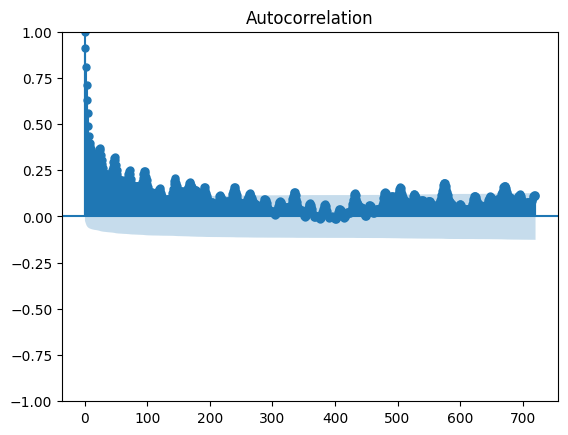

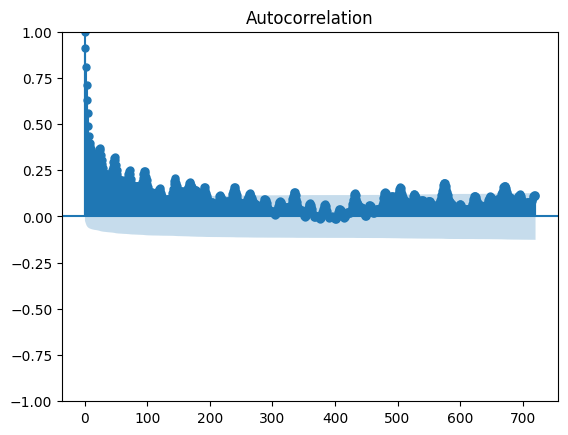

In [251]:
plot_acf(df1['y'],lags=720)

In [253]:
# from statsmodels.tsa.ar_model import AutoReg

# aic_values = []
# for lag in range(1, 3000+1):
#     model = AutoReg(df1['y'], lags=lag).fit()
#     aic_values.append(model.aic)

# best_lag = aic_values.index(min(aic_values)) + 1


In [224]:
f, Pxx = signal.welch(df1['y'], 6000, nperseg=1024)

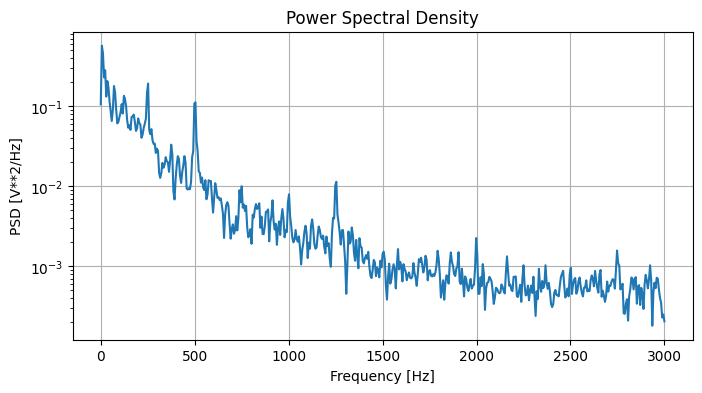

In [225]:
plt.figure(figsize=(8, 4))
plt.semilogy(f, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Power Spectral Density')
plt.grid()
plt.show()

In [154]:
# df1['y']
# seasonal=13

0    20.867
1    21.000
2    20.867
3    20.650
4    20.400
Name: y, dtype: float64

In [156]:
# a=pd.DataFrame(df1['y'])

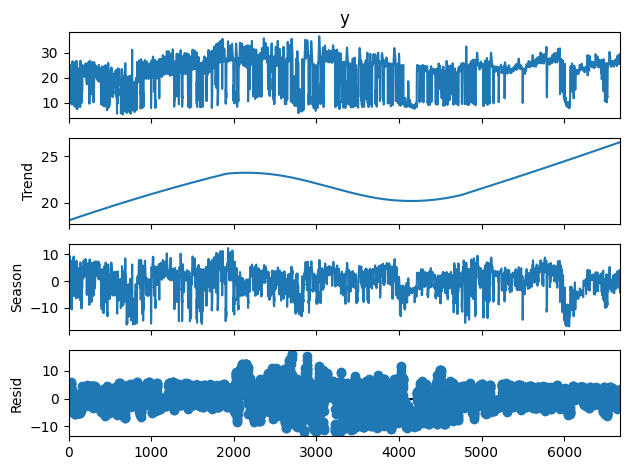

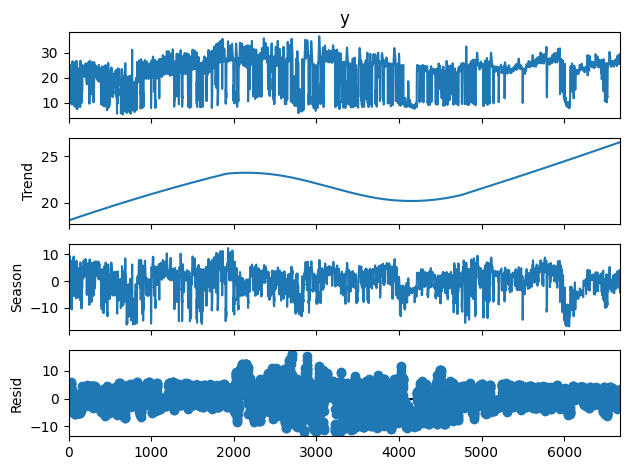

In [161]:
stl = STL(df1['y'],period=24*7*12)
result=stl.fit()
result.plot()

In [162]:
trend=result.trend
trend.head()

0    18.093436
1    18.096458
2    18.099479
3    18.102500
4    18.105521
Name: trend, dtype: float64

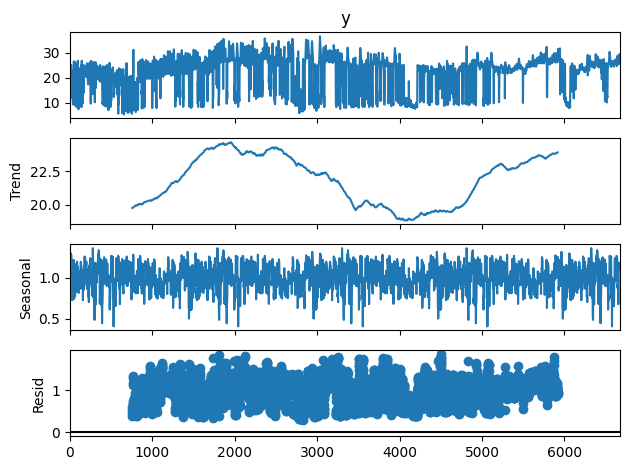

In [148]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df1['y'], model='multiplicative', period=24*7)
result.plot()
plt.show()

In [85]:
a=result.trend

In [87]:
a=pd.DataFrame(a)
a.shape

(6676, 1)

In [88]:
df1.head()

,Datetime1,unique_id,ds,y
0,0,h1,2022-01-04 00:00:00,20.867
1,1,h1,2022-01-04 01:00:00,21.000
2,2,h1,2022-01-04 02:00:00,20.867
3,3,h1,2022-01-04 03:00:00,20.650
4,4,h1,2022-01-04 04:00:00,20.400


In [89]:
a['ds']=df1['ds']
a['unique_id']=df1['unique_id']
a['y']=a['trend']

In [93]:
a=a.dropna().reset_index(drop=True)
a.head()

,trend,ds,unique_id,y
0,18.496214,2022-01-18 00:00:00,h1,18.496214
1,18.494862,2022-01-18 01:00:00,h1,18.494862
2,18.493212,2022-01-18 02:00:00,h1,18.493212
3,18.491488,2022-01-18 03:00:00,h1,18.491488
4,18.489789,2022-01-18 04:00:00,h1,18.489789


In [94]:
a.shape

(6004, 4)

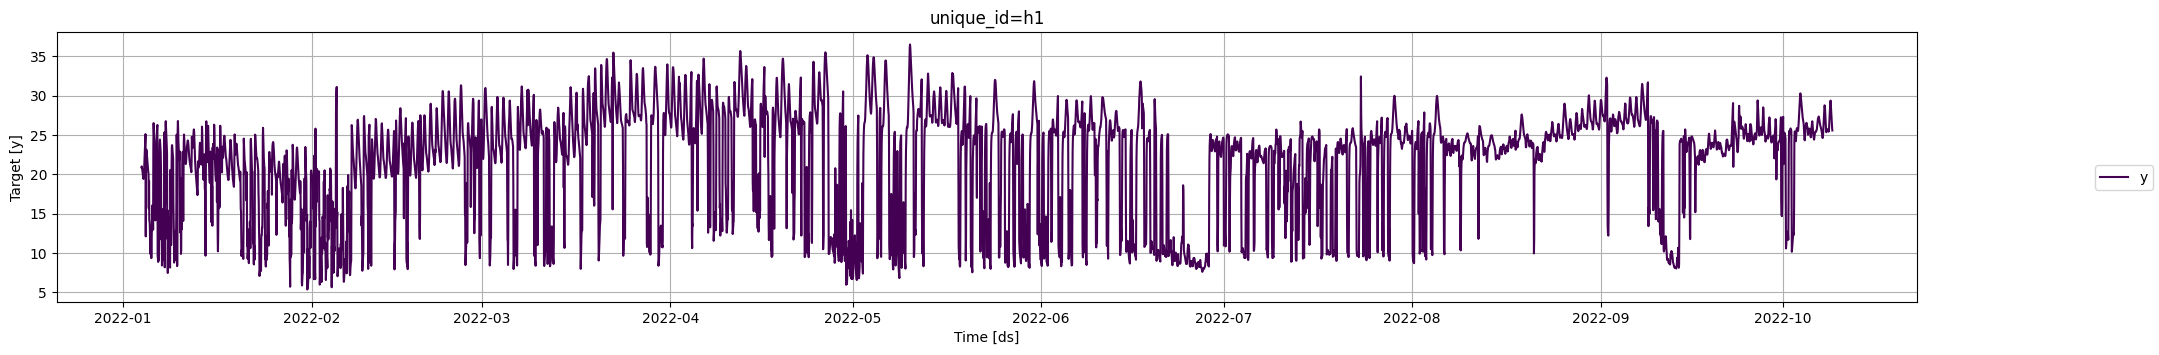

In [74]:
plot_series(df1)

In [178]:
# df1['y']=df1['y']-result.seasonal
# df1['y']=df1['y']-result.trend
# df1.dropna(inplace=True)


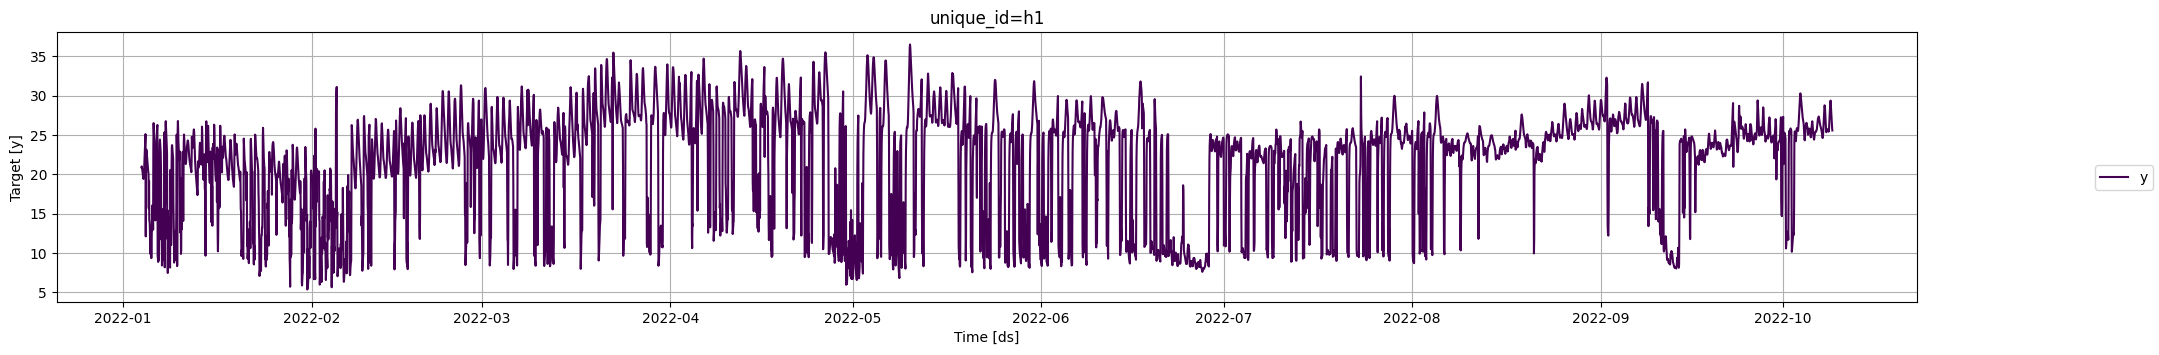

In [279]:
plot_series(df1)

In [81]:
df1['ds'] = pd.to_datetime(df1['ds'])
df1.head()

,Datetime1,unique_id,ds,y
0,0,h1,2022-01-04 00:00:00,20.867
1,1,h1,2022-01-04 01:00:00,21.000
2,2,h1,2022-01-04 02:00:00,20.867
3,3,h1,2022-01-04 03:00:00,20.650
4,4,h1,2022-01-04 04:00:00,20.400


In [95]:
train=a[:5340]
test=a[5340:]
train.shape,test.shape

((5340, 4), (664, 4))

In [292]:
class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **prophet_params):
        self.prophet_params = prophet_params
        self.model = None

    def fit(self, X, y):
        df = X.copy()
        df['y'] = y
        df['ds'] = df.index
        self.model = Prophet(**self.prophet_params)
        self.model.fit(df)
        return self

    def predict(self, X):
        df = X.copy()
        df['ds'] = df.index
        return self.model.predict(df)['yhat'].values

In [136]:
model=XGBRegressor(random_state=990,learning_rate=0.01,n_estimators=500,max_depth=10,reg_lambda=0.2)
ftsc=MLForecast(
    models={
        'xgb':model,
        # 'prophet':ProphetWrapper(),
    },
    freq='H',
    lags=[168,30],
    lag_transforms={
        30:[(rolling_mean,30),(rolling_std,30),(rolling_min,30),(rolling_max,30)],
        168:[(rolling_mean,168),(rolling_std,168),(rolling_min,168),(rolling_max,168)],
    #     350:[(rolling_mean,350),(rolling_std,350),(rolling_min,350),(rolling_max,350)],
    #     720:[(rolling_mean,720),(rolling_std,720),(rolling_min,720),(rolling_max,720)]
    },
    target_transforms=[Differences([350])],
    date_features=['hour','day','weekday','month','year'],
)
ftsc.fit(train,id_col='unique_id',time_col='ds',target_col='y')
# min_child_weight=
# ,gamma=
# ,subsample=
# objective="reg:squarederror",

MLForecast(models=[xgb], freq=H, lag_features=['lag168', 'lag30', 'rolling_mean_lag30_window_size30', 'rolling_std_lag30_window_size30', 'rolling_min_lag30_window_size30', 'rolling_max_lag30_window_size30', 'rolling_mean_lag168_window_size168', 'rolling_std_lag168_window_size168', 'rolling_min_lag168_window_size168', 'rolling_max_lag168_window_size168'], date_features=['hour', 'day', 'weekday', 'month', 'year'], num_threads=1)

In [137]:
preds=ftsc.predict(664)
preds.head()

,unique_id,ds,xgb
0,h1,2022-08-28 12:00:00,25.114328
1,h1,2022-08-28 13:00:00,25.119265
2,h1,2022-08-28 14:00:00,25.110613
3,h1,2022-08-28 15:00:00,25.125094
4,h1,2022-08-28 16:00:00,25.120532


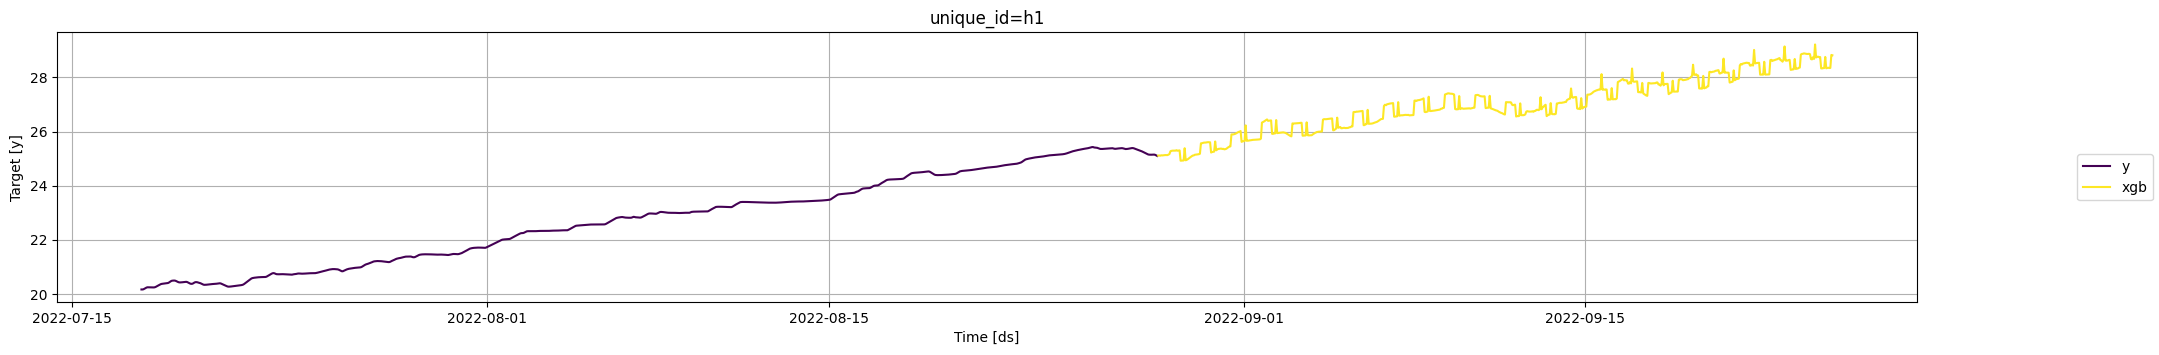

In [138]:
plot_series(train,preds,max_insample_length=1000)

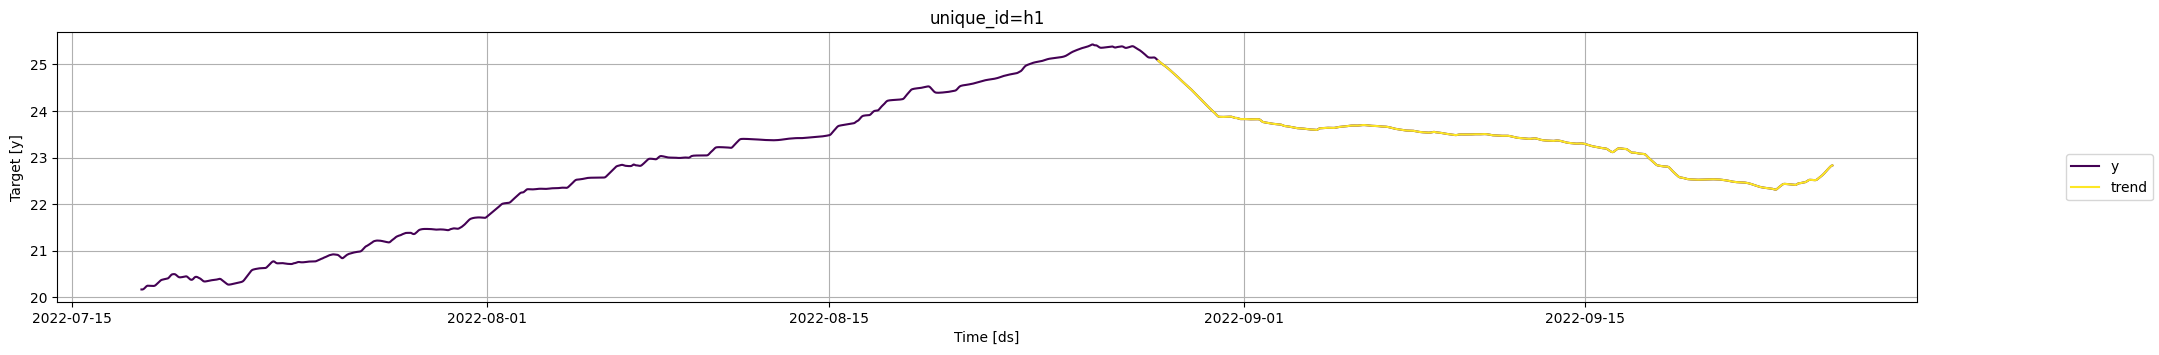

In [105]:
plot_series(train,test,max_insample_length=1000)

In [185]:
# # def custom_accuracy(y_true, y_pred, threshold=0.8):
# #     return y_true - y_pred
# #     # return np.mean(np.abs((y_true - y_pred) / y_true) <= threshold)
# # custom_accuracy(test['y'].reset_index(), preds['xgb'])
# a=test['y'].reset_index()
# a

In [266]:
mse_test = mean_squared_error(test['y'], preds['xgb'])
mse_test

np.float64(520.6605590880602)

In [199]:
a=[]
for i in range(9):
    a.append(df1[i*720:(i+1)*720])

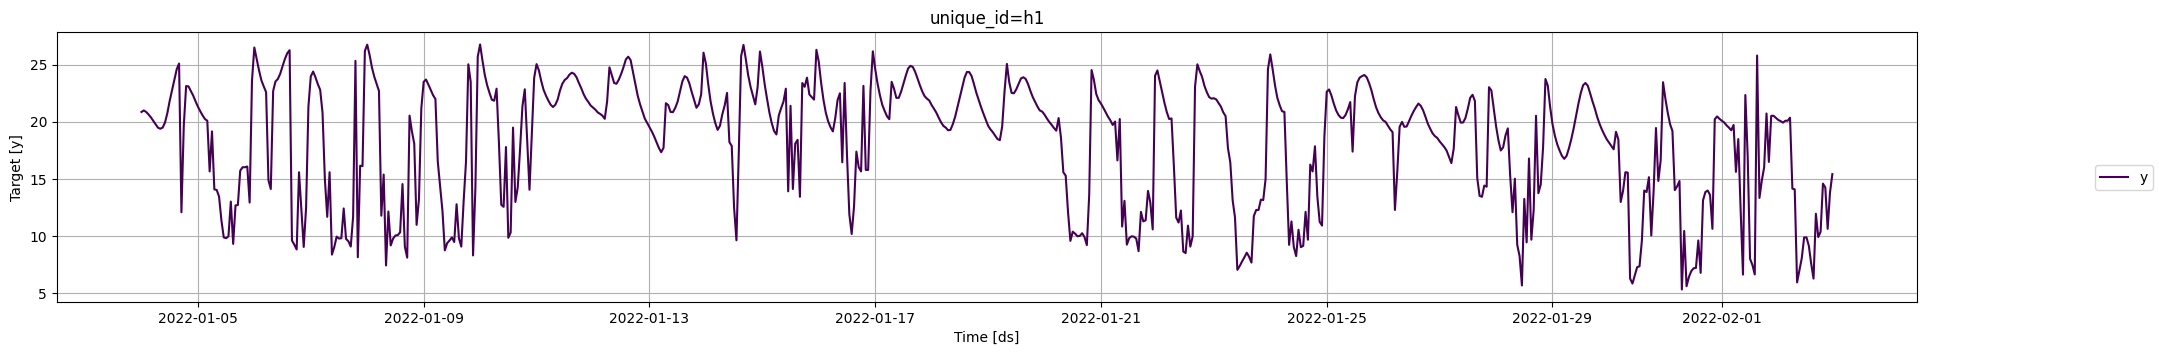

In [200]:
plot_series(a[0])

In [201]:
df1.head()

,Datetime1,unique_id,ds,y
0,0,h1,2022-01-04 00:00:00,20.867
1,1,h1,2022-01-04 01:00:00,21.000
2,2,h1,2022-01-04 02:00:00,20.867
3,3,h1,2022-01-04 03:00:00,20.650
4,4,h1,2022-01-04 04:00:00,20.400


In [222]:
f, Pxx = signal.welch(a[0]['y'],720, nperseg=1024)
sorted_arr = np.sort(Pxx)[::-1]
sorted_arr[1]
np.where(Pxx == sorted_arr[1])[0][0]

np.int64(2)

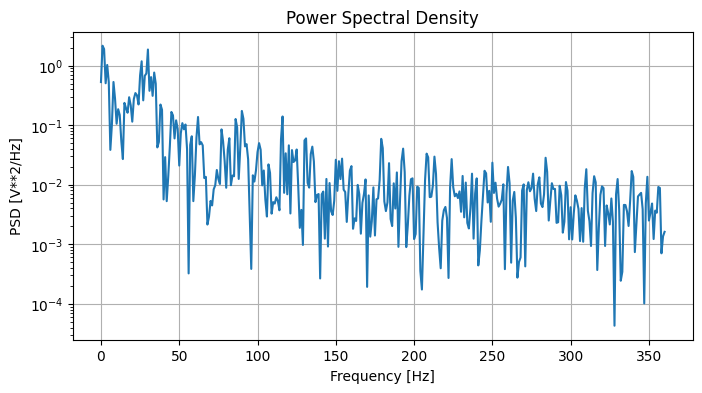

In [214]:
plt.figure(figsize=(8, 4))
plt.semilogy(f, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Power Spectral Density')
plt.grid()
plt.show()

In [202]:
a[0].shape

(720, 4)

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(a[0]['y'], model='multiplicative', period=24*7)
result.plot()
plt.show()


NameError: name 'a' is not defined

In [191]:
a[0]['y']=a[0]['y']-result.seasonal
a[0]['y']=a[0]['y']-result.trend

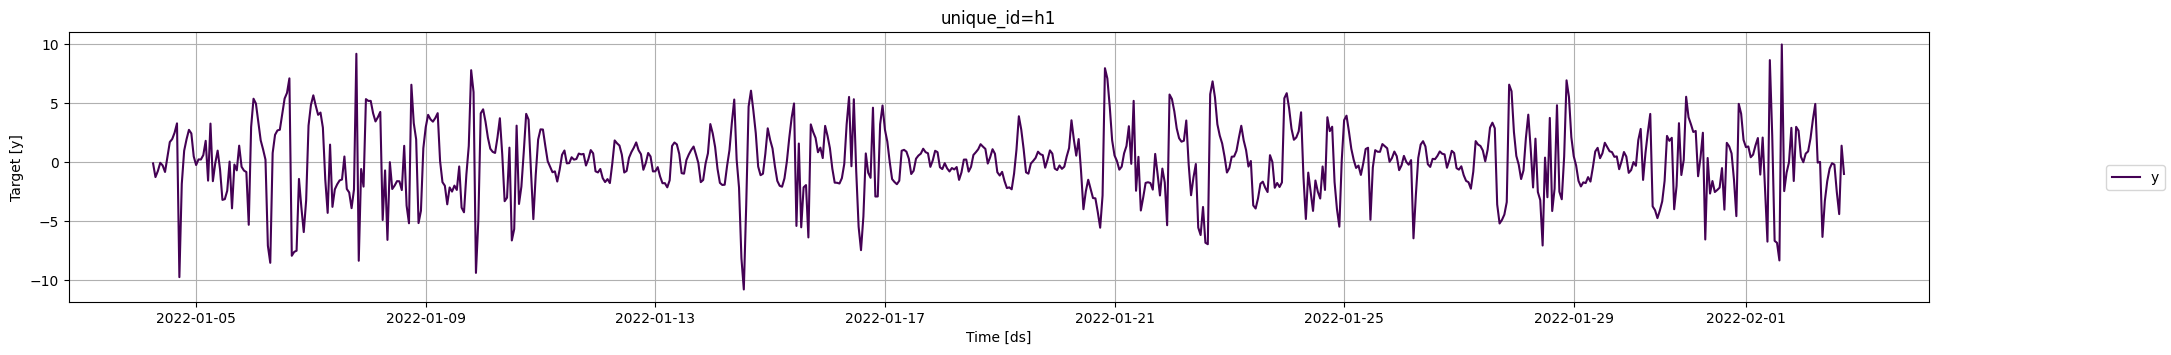

In [192]:
plot_series(a[0])

In [307]:
m=Prophet()
m.fit(train)

08:34:14 - cmdstanpy - INFO - Chain [1] start processing
08:34:15 - cmdstanpy - INFO - Chain [1] done processing


In [308]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
5700,2023-08-10 11:00:00
5701,2023-08-11 11:00:00
5702,2023-08-12 11:00:00
5703,2023-08-13 11:00:00
5704,2023-08-14 11:00:00
